In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from collections import Counter

# 定义一个简单的神经网络
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 200)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 创建模型
def create_model():
    model = SimpleNN()
    return model

# 根据标签将训练集分配到不同客户端
def distribute_data_to_clients(train_dataset, num_clients=10):
    # 统计数据集原本的每个标签的数量
    original_label_counts = Counter(train_dataset.targets.tolist())
    print("Original dataset label counts:")
    for label, count in original_label_counts.items():
        print(f"Label {label}: {count} samples")

    clients = [[] for _ in range(num_clients)]

    for label in range(num_clients):
        indices = [i for i, target in enumerate(train_dataset.targets) if target == label]
        num_splits = num_clients - label
        split_indices = torch.chunk(torch.tensor(indices), num_splits)
        for i in range(num_splits):
            clients[label + i].extend(split_indices[i].tolist())

    client_subsets = [Subset(train_dataset, client_data) for client_data in clients]

    # 输出每个客户端的每个标签的数量
    for i, client_data in enumerate(client_subsets):
        client_targets = [train_dataset.targets[idx] for idx in client_data.indices]
        client_label_counts = Counter(client_targets)

        print(f"Client {i} label counts:")
        l = [0,0,0,0,0,0,0,0,0,0]
        for label, count in client_label_counts.items():
            if label == 0:
                l[0] += 1
            if label == 1:
                l[1] += 1
            if label == 2:
                l[2] += 1
            if label == 3:
                l[3] += 1
            if label == 4:
                l[4] += 1
            if label == 5:
                l[5] += 1
            if label == 6:
                l[6] += 1
            if label == 7:
                l[7] += 1
            if label == 8:
                l[8] += 1
            if label == 9:
                l[9] += 1
        print(l)

    return client_subsets

# 训练函数
def train(model, data_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, targets) in enumerate(data_loader):
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

# 联邦加权平均函数，考虑各客户端的数据量
def federated_weighted_avg(weights, num_samples):
    avg_weights = []
    total_samples = sum(num_samples)
    for i in range(len(weights[0])):
        weighted_sum = sum(weights[j][i] * num_samples[j] / total_samples for j in range(len(weights)))
        avg_weights.append(weighted_sum)
    return avg_weights

def federated_learning(global_model, client_subsets, criterion, hyperparams, test_loader=None):
    """
    联邦学习主循环函数。

    参数:
    - global_model: 全局模型。
    - client_subsets: 每个客户端的数据子集列表。
    - criterion: 损失函数。
    - hyperparams: 超参数字典，包含 num_rounds、learning_rate、batch_size 和 epochs_per_client。
    - test_loader: 测试数据加载器。

    返回:
    - loss_history: 每轮测试的损失列表。
    - accuracy_history: 每轮测试的准确率列表。
    - final_accuracy: 最终全局模型的准确率。
    """
    num_rounds = hyperparams.get('num_rounds', 5)
    learning_rate = hyperparams.get('learning_rate', 0.01)
    batch_size = hyperparams.get('batch_size', 64)
    epochs_per_client = hyperparams.get('epochs_per_client', 1)

    loss_history = []
    accuracy_history = []

    for round_num in range(num_rounds):
        client_weights = []
        num_samples = []

        # 遍历每个客户端的数据子集
        for client_data in client_subsets:
            client_loader = torch.utils.data.DataLoader(client_data, batch_size=batch_size, shuffle=True)
            model = create_model()
            model.load_state_dict(global_model.state_dict())

            optimizer = optim.SGD(model.parameters(), lr=learning_rate)
            train(model, client_loader, criterion, optimizer, epochs=epochs_per_client)

            # 保存客户端模型的权重
            model_weights = [param.data.clone() for param in model.parameters()]
            client_weights.append(model_weights)
            num_samples.append(len(client_data))

        # 使用加权平均聚合权重并更新全局模型
        new_weights = federated_weighted_avg(client_weights, num_samples)
        state_dict = global_model.state_dict()
        new_state_dict = {key: value for key, value in zip(state_dict.keys(), new_weights)}
        global_model.load_state_dict(new_state_dict)

        # 在测试集上评估全局模型并记录损失和准确率
        if test_loader is not None:
            test_loss, accuracy = test(global_model, test_loader, criterion)
            loss_history.append(test_loss)
            accuracy_history.append(accuracy)
            print(f'Round {round_num + 1} Test Loss: {test_loss:.4f}and Test Accuracy: {accuracy * 100:.2f} %')

    # 如果提供了测试加载器，则绘制损失和准确率与联邦学习轮次的关系图
    if test_loader is not None and loss_history and accuracy_history:
        plot_loss_accuracy_history(loss_history, accuracy_history)

    final_accuracy = accuracy_history[-1] if accuracy_history else None

    return loss_history, accuracy_history, final_accuracy

# 测试函数
def test(model, data_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for data, targets in data_loader:
            outputs = model(data)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    accuracy = correct / total
    test_loss /= total
    return test_loss, accuracy

def plot_loss_accuracy_history(loss_history, accuracy_history):
    """
    绘制测试损失和准确率随联邦学习轮次的变化图。

    参数:
    - loss_history: 损失历史列表。
    - accuracy_history: 准确率历史列表。
    """
    x_values = list(range(1, len(loss_history) + 1))
    y_values_loss = loss_history
    y_values_accuracy = [acc * 100 for acc in accuracy_history]

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(x_values, y_values_loss)
    plt.xlabel('Federated Learning Rounds')
    plt.ylabel('Test Loss')
    plt.title('Test Loss vs Federated Learning Rounds')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(x_values, y_values_accuracy)
    plt.xlabel('Federated Learning Rounds')
    plt.ylabel('Test Accuracy (%)')
    plt.title('Test Accuracy vs Federated Learning Rounds')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    final_accuracy = accuracy_history[-1]
    print(f'Final Test Accuracy: {final_accuracy * 100:.2f} %')

transform = transforms.Compose([
    transforms.ToTensor(),
])

# 加载 MNIST 数据集
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# 调用函数
client_subsets = distribute_data_to_clients(train_dataset, num_clients=10)

# 创建测试数据加载器
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# 调用 federated_learning 函数时传入超参数字典
hyperparams = {
    'num_rounds': 100,
    'learning_rate': 0.01,
    'batch_size': 64,
    'epochs_per_client': 5
}

loss_history, accuracy_history, final_accuracy = federated_learning(
    global_model=create_model(),
    client_subsets=client_subsets,
    criterion=nn.CrossEntropyLoss(),
    hyperparams=hyperparams,
    test_loader=test_loader
)


Original dataset label counts:
Label 5: 5421 samples
Label 0: 5923 samples
Label 4: 5842 samples
Label 1: 6742 samples
Label 9: 5949 samples
Label 2: 5958 samples
Label 3: 6131 samples
Label 6: 5918 samples
Label 7: 6265 samples
Label 8: 5851 samples
Client 0 label counts:
[593, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Client 1 label counts:
[593, 750, 0, 0, 0, 0, 0, 0, 0, 0]
Client 2 label counts:
[593, 750, 745, 0, 0, 0, 0, 0, 0, 0]
Client 3 label counts:
[593, 750, 745, 876, 0, 0, 0, 0, 0, 0]
Client 4 label counts:
[593, 750, 745, 876, 974, 0, 0, 0, 0, 0]
Client 5 label counts:
[593, 750, 745, 876, 974, 1085, 0, 0, 0, 0]
Client 6 label counts:
[593, 750, 745, 876, 974, 1085, 1480, 0, 0, 0]
Client 7 label counts:
[593, 750, 745, 876, 974, 1085, 1480, 2089, 0, 0]
Client 8 label counts:
[593, 750, 745, 876, 974, 1085, 1480, 2089, 2926, 0]
Client 9 label counts:
[586, 742, 743, 875, 972, 1081, 1478, 2087, 2925, 5949]


KeyboardInterrupt: 

Original dataset label counts:
Label 5: 5421 samples
Label 0: 5923 samples
Label 4: 5842 samples
Label 1: 6742 samples
Label 9: 5949 samples
Label 2: 5958 samples
Label 3: 6131 samples
Label 6: 5918 samples
Label 7: 6265 samples
Label 8: 5851 samples
Client 0 label counts:
[593, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Client 1 label counts:
[593, 750, 0, 0, 0, 0, 0, 0, 0, 0]
Client 2 label counts:
[593, 750, 745, 0, 0, 0, 0, 0, 0, 0]
Client 3 label counts:
[593, 750, 745, 876, 0, 0, 0, 0, 0, 0]
Client 4 label counts:
[593, 750, 745, 876, 974, 0, 0, 0, 0, 0]
Client 5 label counts:
[593, 750, 745, 876, 974, 1085, 0, 0, 0, 0]
Client 6 label counts:
[593, 750, 745, 876, 974, 1085, 1480, 0, 0, 0]
Client 7 label counts:
[593, 750, 745, 876, 974, 1085, 1480, 2089, 0, 0]
Client 8 label counts:
[593, 750, 745, 876, 974, 1085, 1480, 2089, 2926, 0]
Client 9 label counts:
[586, 742, 743, 875, 972, 1081, 1478, 2087, 2925, 5949]
Round 1 Test Loss: 1.2365 and Test Accuracy: 66.43 %
Round 2 Test Loss: 0.8895 and T

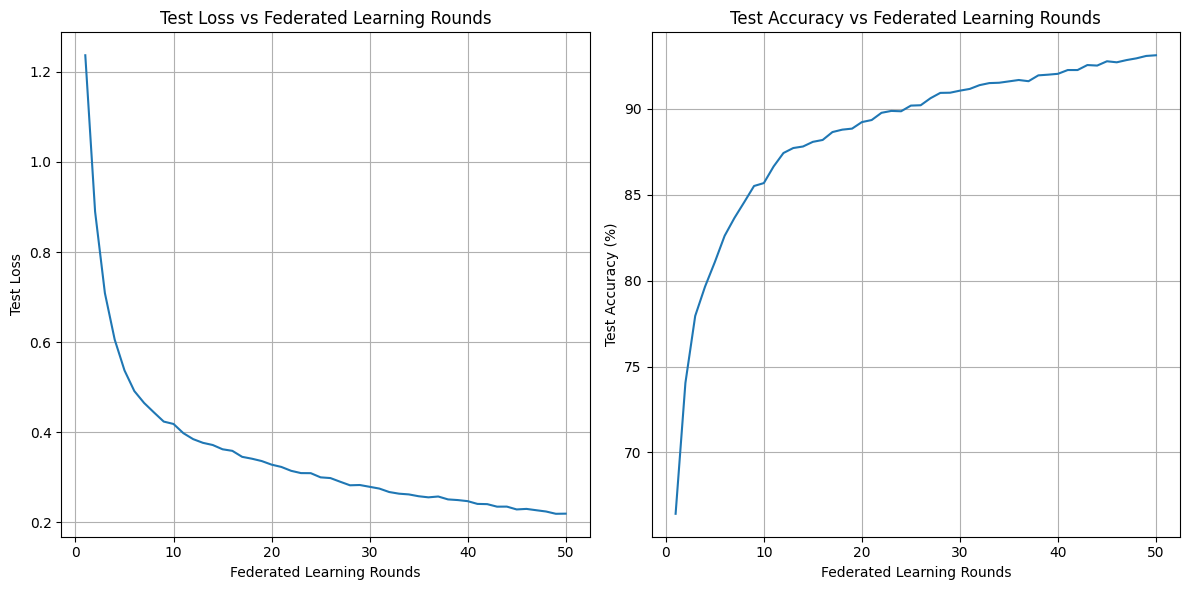

Final Test Accuracy: 93.12 %


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from collections import Counter

# 定义一个简单的神经网络
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 200)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 创建模型
def create_model():
    model = SimpleNN()
    return model

# 根据标签将训练集分配到不同客户端
def distribute_data_to_clients(train_dataset, num_clients=10):
    # 统计数据集原本的每个标签的数量
    original_label_counts = Counter(train_dataset.targets.tolist())
    print("Original dataset label counts:")
    for label, count in original_label_counts.items():
        print(f"Label {label}: {count} samples")

    clients = [[] for _ in range(num_clients)]

    for label in range(num_clients):
        indices = [i for i, target in enumerate(train_dataset.targets) if target == label]
        num_splits = num_clients - label
        split_indices = torch.chunk(torch.tensor(indices), num_splits)
        for i in range(num_splits):
            clients[label + i].extend(split_indices[i].tolist())

    client_subsets = [Subset(train_dataset, client_data) for client_data in clients]

    # 输出每个客户端的每个标签的数量
    for i, client_data in enumerate(client_subsets):
        client_targets = [train_dataset.targets[idx] for idx in client_data.indices]
        client_label_counts = Counter(client_targets)

        print(f"Client {i} label counts:")
        l = [0,0,0,0,0,0,0,0,0,0]
        for label, count in client_label_counts.items():
            if label == 0:
                l[0] += 1
            if label == 1:
                l[1] += 1
            if label == 2:
                l[2] += 1
            if label == 3:
                l[3] += 1
            if label == 4:
                l[4] += 1
            if label == 5:
                l[5] += 1
            if label == 6:
                l[6] += 1
            if label == 7:
                l[7] += 1
            if label == 8:
                l[8] += 1
            if label == 9:
                l[9] += 1
        print(l)

    return client_subsets

class EWC(object):
    def __init__(self, model, dataloader, lambda_ewc):
        self.model = model
        self.lambda_ewc = lambda_ewc
        self.dataloader = dataloader
        self.prev_params = self._get_params()
        self.fisher_information = self._compute_fisher_information()
    
    def _get_params(self):
        params = {}
        for name, param in self.model.named_parameters():
            params[name] = param.clone()
        return params

    
    def _compute_fisher_information(self):
        fisher_information = {}
        self.model.eval()
        for name, param in self.model.named_parameters():
            fisher_information[name] = torch.zeros_like(param)
        
        for data, target in self.dataloader:
            output = self.model(data)
            loss = nn.CrossEntropyLoss()(output, target)
            self.model.zero_grad()
            loss.backward()
            
            for name, param in self.model.named_parameters():
                fisher_information[name] += param.grad ** 2 / len(self.dataloader)
        
        return fisher_information
    
    def loss(self):
        ewc_loss = 0
        for name, param in self.model.named_parameters():
            if name in self.fisher_information:
                ewc_loss += (self.fisher_information[name] * (param - self.prev_params[name]) ** 2).sum()
        return self.lambda_ewc * ewc_loss

# 训练函数
def train_with_ewc(model, data_loader, criterion, optimizer, ewc, epochs):
    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, targets) in enumerate(data_loader):
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            ewc_loss = ewc.loss()
            total_loss = loss + ewc_loss
            total_loss.backward()
            optimizer.step()

# 联邦加权平均函数，考虑各客户端的数据量
def federated_weighted_avg(weights, num_samples):
    avg_weights = []
    total_samples = sum(num_samples)
    for i in range(len(weights[0])):
        weighted_sum = sum(weights[j][i] * num_samples[j] / total_samples for j in range(len(weights)))
        avg_weights.append(weighted_sum)
    return avg_weights

def federated_learning(global_model, client_subsets, criterion, hyperparams, test_loader=None):
    num_rounds = hyperparams.get('num_rounds', 5)
    learning_rate = hyperparams.get('learning_rate', 0.01)
    batch_size = hyperparams.get('batch_size', 64)
    epochs_per_client = hyperparams.get('epochs_per_client', 1)
    lambda_ewc = hyperparams.get('lambda_ewc', 0.1)

    loss_history = []
    accuracy_history = []

    for round_num in range(num_rounds):
        client_weights = []
        num_samples = []

        for client_data in client_subsets:
            client_loader = torch.utils.data.DataLoader(client_data, batch_size=batch_size, shuffle=True)
            model = create_model()
            model.load_state_dict(global_model.state_dict())
            
            ewc = EWC(model, client_loader, lambda_ewc)
            optimizer = optim.SGD(model.parameters(), lr=learning_rate)
            train_with_ewc(model, client_loader, criterion, optimizer, ewc, epochs=epochs_per_client)

            model_weights = [param.data.clone() for param in model.parameters()]
            client_weights.append(model_weights)
            num_samples.append(len(client_data))

        new_weights = federated_weighted_avg(client_weights, num_samples)
        state_dict = global_model.state_dict()
        new_state_dict = {key: value for key, value in zip(state_dict.keys(), new_weights)}
        global_model.load_state_dict(new_state_dict)

        if test_loader is not None:
            test_loss, accuracy = test(global_model, test_loader, criterion)
            loss_history.append(test_loss)
            accuracy_history.append(accuracy)
            print(f'Round {round_num + 1} Test Loss: {test_loss:.4f} and Test Accuracy: {accuracy * 100:.2f} %')

    if test_loader is not None and loss_history and accuracy_history:
        plot_loss_accuracy_history(loss_history, accuracy_history)

    final_accuracy = accuracy_history[-1] if accuracy_history else None

    return loss_history, accuracy_history, final_accuracy

# 测试函数
def test(model, data_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for data, targets in data_loader:
            outputs = model(data)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    accuracy = correct / total
    test_loss /= total
    return test_loss, accuracy

def plot_loss_accuracy_history(loss_history, accuracy_history):
    """
    绘制测试损失和准确率随联邦学习轮次的变化图。

    参数:
    - loss_history: 损失历史列表。
    - accuracy_history: 准确率历史列表。
    """
    x_values = list(range(1, len(loss_history) + 1))
    y_values_loss = loss_history
    y_values_accuracy = [acc * 100 for acc in accuracy_history]

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(x_values, y_values_loss)
    plt.xlabel('Federated Learning Rounds')
    plt.ylabel('Test Loss')
    plt.title('Test Loss vs Federated Learning Rounds')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(x_values, y_values_accuracy)
    plt.xlabel('Federated Learning Rounds')
    plt.ylabel('Test Accuracy (%)')
    plt.title('Test Accuracy vs Federated Learning Rounds')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    final_accuracy = accuracy_history[-1]
    print(f'Final Test Accuracy: {final_accuracy * 100:.2f} %')

transform = transforms.Compose([
    transforms.ToTensor(),
])

# 加载 MNIST 数据集
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# 调用函数
client_subsets = distribute_data_to_clients(train_dataset, num_clients=10)

# 创建测试数据加载器
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# 调用 federated_learning 函数时传入超参数字典
hyperparams = {
    'num_rounds': 50,
    'learning_rate': 0.01,
    'batch_size': 64,
    'epochs_per_client': 5
}

loss_history, accuracy_history, final_accuracy = federated_learning(
    global_model=create_model(),
    client_subsets=client_subsets,
    criterion=nn.CrossEntropyLoss(),
    hyperparams=hyperparams,
    test_loader=test_loader
)
